In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets 
import torchvision.transforms as transforms

In [2]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16
out_size = 10

epochs = 10
batch_size = 64
learning_rate = 0.001

In [3]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [4]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)     #784 - 32
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)   #32 - 16
        self.fc2 = nn.Linear(hidden_size1, out_size)       #16 - 10
        self.tanh = nn.Tanh()
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.fc0.weight, gain=nn.init.calculate_gain('tanh')) 
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('tanh'))

    def forward(self, x):
        out = self.tanh(self.fc0(x))
        out = self.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [5]:
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [6]:
for epoch in range(epochs):
    correct_train = 0
    running_loss = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28*28)
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
            
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum()
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch [{}/{}], Training Loss: {:.3f}, Training Accuracy: {:.3f}%'.format
          (epoch+1, epochs, running_loss/len(train_loader), (100*correct_train.double()/len(train_dataset))))
print("DONE TRAINING!")

torch.save(net.state_dict(), f'02_ffn_mnist_full.pth')

Epoch [1/10], Training Loss: 0.451, Training Accuracy: 87.690%
Epoch [2/10], Training Loss: 0.218, Training Accuracy: 93.888%
Epoch [3/10], Training Loss: 0.164, Training Accuracy: 95.250%
Epoch [4/10], Training Loss: 0.137, Training Accuracy: 96.057%
Epoch [5/10], Training Loss: 0.118, Training Accuracy: 96.612%
Epoch [6/10], Training Loss: 0.104, Training Accuracy: 96.933%
Epoch [7/10], Training Loss: 0.095, Training Accuracy: 97.292%
Epoch [8/10], Training Loss: 0.086, Training Accuracy: 97.445%
Epoch [9/10], Training Loss: 0.079, Training Accuracy: 97.708%
Epoch [10/10], Training Loss: 0.073, Training Accuracy: 97.862%
DONE TRAINING!


In [7]:
with torch.no_grad():
    correct = 0

    for images, labels in test_loader:
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
            
        images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / len(test_dataset)))

Accuracy of the network on the 10000 test images: 96.66 %


pygame 2.6.1 (SDL 2.28.4, Python 3.12.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/kns357/Desktop/ann_ma_kaito/venv0/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Tensor shape: torch.Size([1, 28, 28])


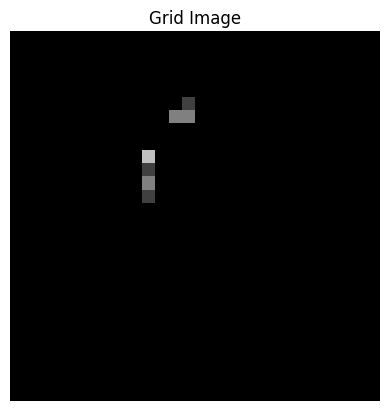

In [8]:
import pygame
import numpy as np
import torch
import matplotlib.pyplot as plt

# ---- Config ----
GRID = 28
CELL = 20                 # pixel size of each cell on screen
WIDTH, HEIGHT = GRID*CELL, GRID*CELL
LEVELS = [0.0, 0.25, 0.5, 0.75, 1.0]   # grayscale levels

# ---- Init ----
pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Click Grid (Enter=Save, C=Clear)")
clock = pygame.time.Clock()

# State: 2D array in [0,1]
grid = np.zeros((GRID, GRID), dtype=np.float32)

def draw_grid():
    screen.fill((0,0,0))
    # Fill cells
    for r in range(GRID):
        for c in range(GRID):
            v = grid[r, c]
            g = int(v*255)
            rect = pygame.Rect(c*CELL, r*CELL, CELL, CELL)
            pygame.draw.rect(screen, (g,g,g), rect)
    # Grid lines
    for r in range(GRID+1):
        pygame.draw.line(screen, (40,40,40), (0, r*CELL), (WIDTH, r*CELL))
    for c in range(GRID+1):
        pygame.draw.line(screen, (40,40,40), (c*CELL, 0), (c*CELL, HEIGHT))

def cycle_value(v, direction=+1):
    """Cycle v through LEVELS up (+1) or down (-1)."""
    idx = min(range(len(LEVELS)), key=lambda i: abs(LEVELS[i]-v))
    idx = (idx + direction) % len(LEVELS)
    return LEVELS[idx]

running = True
saved = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_ESCAPE:
                running = False
            elif event.key == pygame.K_c:
                grid.fill(0.0)
            elif event.key == pygame.K_RETURN:
                saved = True
                running = False

        if event.type == pygame.MOUSEBUTTONDOWN:
            x, y = pygame.mouse.get_pos()
            c, r = x // CELL, y // CELL
            if 0 <= r < GRID and 0 <= c < GRID:
                if event.button == 1:       # left click: up
                    grid[r, c] = cycle_value(grid[r, c], +1)
                elif event.button == 3:     # right click: down
                    grid[r, c] = cycle_value(grid[r, c], -1)

    draw_grid()
    pygame.display.flip()
    clock.tick(60)

pygame.quit()

if saved:
    # To tensor [1, 28, 28], values in [0,1]
    img = torch.tensor(grid, dtype=torch.float32).unsqueeze(0)

    print("Tensor shape:", img.shape)
    # Preview with matplotlib
    plt.imshow(img.squeeze(0).numpy(), cmap="gray", vmin=0, vmax=1)
    plt.title("Grid Image")
    plt.axis("off")
    plt.show()
else:
    print("Closed without saving (no tensor created).")


In [9]:
pred = net(img.cuda().view(-1, 28*28))
print(pred)

tensor([[ 0.5645, -0.3813, -3.4977,  0.2270, -1.3573,  3.7030, -1.6067,  3.6827,
         -1.8909,  0.2640]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [10]:
pred = net(tensor.cuda().view(-1, 28*28))
print(pred)

NameError: name 'tensor' is not defined